<a href="https://colab.research.google.com/github/Bmo411/Deeplearning/blob/main/perrosGPUFourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization,
    Flatten, Dense, Reshape, concatenate, Lambda, Layer
)
from keras.initializers import orthogonal
import keras
from keras import backend as K
from keras.saving import register_keras_serializable

2025-03-19 13:43:26.945955: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 13:43:26.955011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742413406.964462   20390 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742413406.967268   20390 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 13:43:26.978594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
import requests
import os

# URL de la API para obtener imágenes de perros
url = "https://dog.ceo/api/breeds/image/random"
carpeta = "perros"
'''
# Crea la carpeta si no existe
if not os.path.exists(carpeta):
    os.makedirs(carpeta)

# Descargar imágenes

for i in range(200):
    response = requests.get(url)
    if response.status_code == 200:
        image_url = response.json()["message"]
        image_data = requests.get(image_url).content
        file_path = os.path.join(carpeta, f"perro_{i+1}.jpg")
        with open(file_path, "wb") as file:
            file.write(image_data)
        print(f"Imagen {i+1} descargada en {file_path}")
    else:
        print(f"Error al descargar la imagen {i+1}")

print("Descarga completa.")
'''

'\n# Crea la carpeta si no existe\nif not os.path.exists(carpeta):\n    os.makedirs(carpeta)\n\n# Descargar imágenes\n\nfor i in range(200):\n    response = requests.get(url)\n    if response.status_code == 200:\n        image_url = response.json()["message"]\n        image_data = requests.get(image_url).content\n        file_path = os.path.join(carpeta, f"perro_{i+1}.jpg")\n        with open(file_path, "wb") as file:\n            file.write(image_data)\n        print(f"Imagen {i+1} descargada en {file_path}")\n    else:\n        print(f"Error al descargar la imagen {i+1}")\n\nprint("Descarga completa.")\n'

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Ruta de las imágenes
carpeta = "perros"
dimensiones = (256, 256)  # Dimensión CIFAR-100

# Lista para guardar imágenes normalizadas
imagenes_normalizadas = []

for imagen in os.listdir(carpeta):
    img_path = os.path.join(carpeta, imagen)
    img = Image.open(img_path).convert("RGB")  # Convertir a RGB
    img = img.resize(dimensiones)  # Redimensionar

    # Convertir a array numpy
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalizar a [0, 1]

    imagenes_normalizadas.append(img_array)
    #print(f"{imagen} procesada")

# Convertir la lista en un array de numpy
imagenes_originales = np.array(imagenes_normalizadas)

# Verificar dimensiones finales
print("Shape final:", imagenes_originales.shape)  # (10, 32, 32, 3)

Shape final: (200, 256, 256, 3)


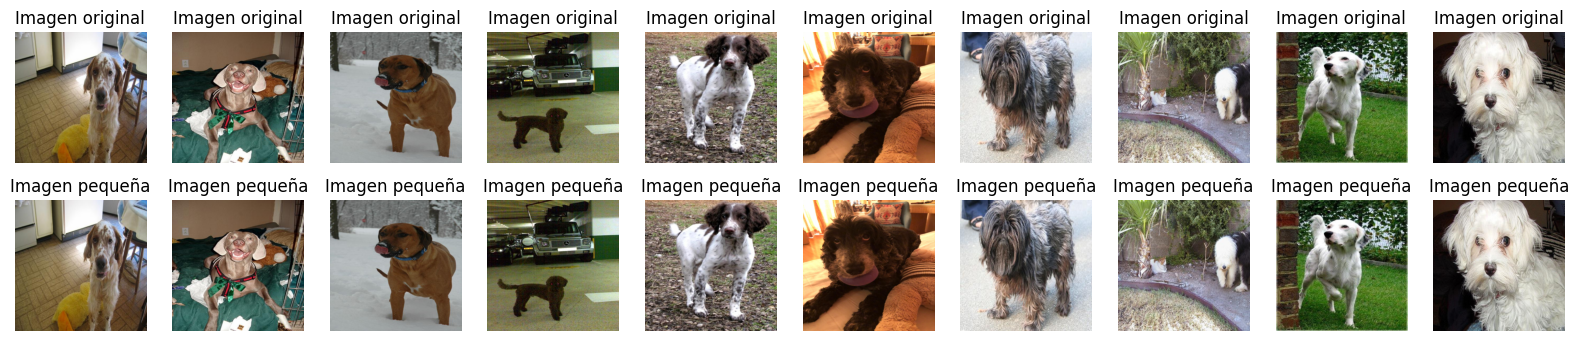

Shape final: (200, 256, 256, 3)


In [ ]:
#Hacemos las imagenes mucho mas pequenas
imagenes_red = imagenes_originales[:, ::, ::, :]
#mostramos imagenes original y pequena
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
  ax[0,i].imshow(imagenes_originales[i])
  ax[0,i].set_title("Imagen original")
  ax[1,i].imshow(imagenes_red[i])
  ax[1,i].set_title("Imagen pequeña")
  ax[0,i].axis('off')
  ax[1,i].axis('off')
plt.show()
print("Shape final:", imagenes_red.shape)

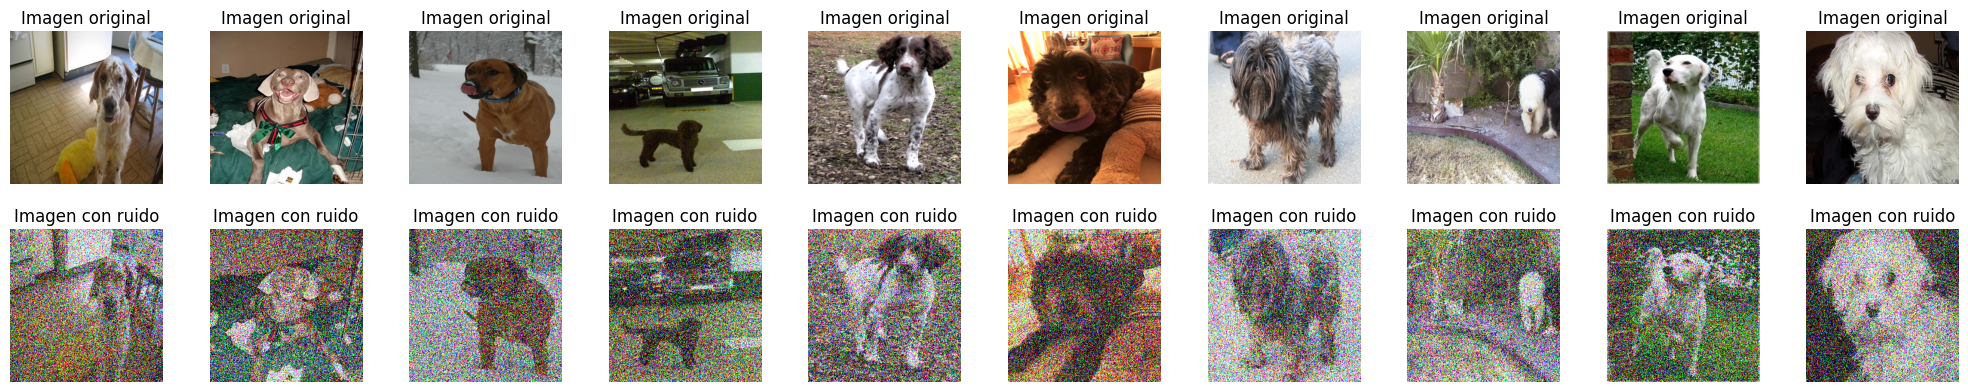

Shape final: (200, 256, 256, 3)


In [ ]:


from skimage.util import random_noise

# Añadir ruido gaussiano a las imágenes usando skimage.util.random_noise
def add_gaussian_noise(imagenes_red):
    imagenes_ruido = random_noise(imagenes_red, mode='gaussian', mean=0, var=0.3)
    return imagenes_ruido

# Mostrar imágenes originales y con ruido
def display_noisy_images(imagenes_red, imagenes_ruido):
    fig, ax = plt.subplots(2, 10, figsize=(20, 4))  # Crear una cuadrícula de 2x10
    fig.tight_layout(pad=0.3)

    for i in range(10):
        ax[0, i].imshow(imagenes_red[i])  # Imagen original
        ax[0, i].set_title("Imagen original")
        ax[0, i].axis('off')

        ax[1, i].imshow(imagenes_ruido[i])  # Imagen con ruido
        ax[1, i].set_title("Imagen con ruido")
        ax[1, i].axis('off')

    plt.show()

imagenes_ruido = add_gaussian_noise(imagenes_red)
display_noisy_images(imagenes_red,imagenes_ruido)
print("Shape final:", imagenes_ruido.shape)


In [ ]:
# Función para capas convolucionales en el encoder
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
               kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = LeakyReLU(name=prefix+'grelu')(x)
    x = Dropout(0.2, name=prefix+'drop')((x))
    x = BatchNormalization(name=prefix+'conv_bn')(x)
    return x

# Función para capas transpuestas en el decoder
def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                        kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = LeakyReLU(name=prefix+'grelu')(x)
    x = Dropout(0.2, name=prefix+'drop')((x))
    x = BatchNormalization(name=prefix+'conv_bn')(x)
    return x

# Capa de Transformada de Fourier
class FourierTransformLayer(Layer):
    def call(self, inputs):
        fourier = tf.signal.fft2d(tf.cast(inputs, tf.complex64))
        fourier = tf.abs(fourier)
        return tf.concat([tf.math.real(fourier), tf.math.imag(fourier)], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3] * 2)

# Capa de Transformada Inversa de Fourier
class InverseFourierTransformLayer(Layer):
    def call(self, inputs):
        real_part, imag_part = tf.split(inputs, num_or_size_splits=2, axis=-1)
        complex_fourier = tf.complex(real_part, imag_part)
        return tf.abs(tf.signal.ifft2d(complex_fourier))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3] // 2)


# Encoder
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=2, padding='same', block_id=1)  # Reduce a 128x128
    conv2 = Conv2DLayer(conv1, 128, 3, strides=2, padding='same', block_id=2)  # Reduce a 64x64

    # 64 x 64
    conv3 = Conv2DLayer(conv2, 256, 3, strides=2, padding='same', block_id=3)  # Reduce a 32x32

    # 32 x 32
    conv4 = Conv2DLayer(conv3, 512, 3, strides=2, padding='same', block_id=4)  # Reduce a 16x16

    # 16 x 16
    conv5 = Conv2DLayer(conv4, 512, 3, strides=2, padding='same', block_id=5)  # Reduce a 8x8

    # Aplicamos Fourier Transform en el bottleneck
    fourier = FourierTransformLayer()(conv5)

    shape_before_flattening = list(fourier.shape)

    x = Flatten()(fourier)
    latent = Dense(latent_dim, activation="relu")(x)  # Reducir dimensionalidad

    encoder = Model(inputs, [latent, conv1, conv2, conv3, conv4, conv5, fourier], name="encoder")  # Devuelve más skips

    return encoder, shape_before_flattening

# Decoder
def build_decoder(shape_before_flattening, latent_dim):
    latent_inputs = Input(shape=(latent_dim,))

    # Input para los skip connections
    skip1 = Input(shape=(128, 128, 64))   # conv1
    skip2 = Input(shape=(64, 64, 128))    # conv2
    skip3 = Input(shape=(32, 32, 256))    # conv3
    skip4 = Input(shape=(16, 16, 512))    # conv4

    x = Dense(np.prod(shape_before_flattening[1:]), activation="relu")(latent_inputs)
    x = Reshape(shape_before_flattening[1:])(x)  # Reshape acorde a la salida del encoder

    # Inversa de Fourier con output_shape definido
    x = InverseFourierTransformLayer()(x)

    # 8 x 8 → 16 x 16
    deconv1 = Transpose_Conv2D(x, 512, 3, strides=2, padding='same', block_id=6)
    skip1_concat = concatenate([deconv1, skip4], name='skip1')

    # 16 x 16 → 32 x 32
    conv6 = Conv2DLayer(skip1_concat, 512, 3, strides=1, padding='same', block_id=7)
    deconv2 = Transpose_Conv2D(conv6, 256, 3, strides=2, padding='same', block_id=8)
    skip2_concat = concatenate([deconv2, skip3], name='skip2')

    # 32 x 32 → 64 x 64
    conv7 = Conv2DLayer(skip2_concat, 256, 3, strides=1, padding='same', block_id=9)
    deconv3 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=10)
    skip3_concat = concatenate([deconv3, skip2], name='skip3')

    # 64 x 64 → 128 x 128
    conv8 = Conv2DLayer(skip3_concat, 128, 3, strides=1, padding='same', block_id=11)
    deconv4 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=12)
    skip4_concat = concatenate([deconv4, skip1], name='skip4')

    # 128 x 128 → 256 x 256 (Salida final)
    outputs = Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid', name='final_conv')(skip4_concat)

    decoder = Model([latent_inputs, skip1, skip2, skip3, skip4], outputs, name="decoder")

    return decoder


In [ ]:
def combined_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true, y_pred))
    return 0.7 * mse_loss + 0.3 * ssim_loss  # Más peso al SSIM


In [ ]:
# Construcción del autoencoder
input_shape = (256, 256, 3)
latent_dim = 1024
encoder, shape_before_flattening = build_encoder(input_shape, latent_dim)
decoder = build_decoder(shape_before_flattening, latent_dim)

# Conectar el encoder con el decoder
inputs = Input(shape=input_shape)
latent, skip1, skip2, skip3, skip4, skip5, fourier = encoder(inputs)
decoded = decoder([latent, skip1, skip2, skip3, skip4])

# Definir el modelo completo
autoencoder = Model(inputs, decoded, name="autoencoder")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="mse", metrics=['accuracy'])

# Mostrar resumen del modelo
autoencoder.summary()

I0000 00:00:1742413412.108652   20390 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 1024),    │ 71,026,560 │ input_layer_6[0]… │
│ (Functional)        │ (None, 128, 128,  │            │                   │
│                     │ 64), (None, 64,   │            │                   │
│                     │ 64, 128), (None,  │            │                   │
│                     │ 32, 32, 256),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 512), (None, 8,   │            │                   │
│                     │ 8, 512), (None,   │            │                   │
│                     │ 8, 8, 1024)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 256, 256,  │ 77,287,875 │ encoder[0][0],    │
│ (Functional)        │ 3)                │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2],    │
│                     │                   │            │ encoder[0][3],    │
│                     │                   │            │ encoder[0][4]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 148,314,435 (565.77 MB)

 Trainable params: 148,307,779 (565.75 MB)

 Non-trainable params: 6,656 (26.00 KB)

In [ ]:
print("Forma de salida del encoder:", encoder.output_shape)
print("Forma de entrada del decoder:", decoder.input_shape)


Forma de salida del encoder: [(None, 1024), (None, 128, 128, 64), (None, 64, 64, 128), (None, 32, 32, 256), (None, 16, 16, 512), (None, 8, 8, 512), (None, 8, 8, 1024)]
Forma de entrada del decoder: [(None, 1024), (None, 128, 128, 64), (None, 64, 64, 128), (None, 32, 32, 256), (None, 16, 16, 512)]


In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(imagenes_ruido,imagenes_red, test_size=0.4, random_state=42)



In [ ]:
xtest.shape

(80, 256, 256, 3)

In [ ]:
# Asegurar que las imágenes de prueba tengan la forma correcta (5, 256, 256, 3)
example_images = xtest[:5]

# Verificar la forma
print(f"Forma de example_images antes del callback: {example_images.shape}")  # Debe ser (5, 256, 256, 3)

assert example_images.shape == (5, 256, 256, 3), "Error: example_images tiene una forma incorrecta"


Forma de example_images antes del callback: (5, 256, 256, 3)


In [ ]:
# Definir rutas para guardar los pesos y logs
saved_weight = "autoencoder_checkpoint.weights.h5"  # Guarda solo los mejores pesos
P_LOGS = "logs"
# Definir batch size antes del entrenamiento
BATCH_SIZE = 16

# Crear directorio si no existe
if not os.path.exists(P_LOGS):
    os.makedirs(P_LOGS)

# Guardar el modelo solo cuando val_loss mejora
modelchk = keras.callbacks.ModelCheckpoint(
    saved_weight,
    monitor='val_loss',  # Guarda basado en la validación
    save_best_only=True,  # Guarda solo los mejores pesos
    save_weights_only=True,  # No guarda la arquitectura, solo los pesos
    mode='min',  # Minimiza val_loss
    verbose=1
)

# Reducir el learning rate si la pérdida no mejora en 8 épocas
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,  # Reduce LR un 30% (más gradual)
    patience=16,  # Reduce más rápido si no mejora en 16 épocas
    min_lr=1e-5,  # Evita que se vuelva demasiado lento
    mode='min',
    verbose=1
)

# Detener el entrenamiento si no mejora en 30 épocas
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=35,  # Espera 30 épocas antes de detener
    restore_best_weights=True,  # Recupera los mejores pesos antes de detenerse
    mode='min',
    verbose=1
)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint


class WandbImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, example_images, interval=25):
        super(WandbImageCallback, self).__init__()
        self.example_images = example_images
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            if hasattr(self.model, "predict"):
                # Obtener reconstrucciones del autoencoder
                reconstructed_images = self.model.predict(self.example_images)

                # Crear figura para visualizar comparaciones
                fig, axes = plt.subplots(2, len(self.example_images), figsize=(12, 6))
                for i in range(len(self.example_images)):
                    axes[0, i].imshow(self.example_images[i])
                    axes[0, i].axis("off")
                    axes[1, i].imshow(np.clip(reconstructed_images[i], 0, 1))
                    axes[1, i].axis("off")

                plt.suptitle(f"Reconstrucción después de {epoch + 1} épocas")

                # Obtener valores de loss y learning_rate si existen en logs
                loss = logs.get("loss", None)
                val_loss = logs.get("val_loss", None)
                learning_rate = logs.get("learning_rate", None)

                # Registrar imagen y métricas en W&B
                wandb.log({
                    "Reconstrucción": wandb.Image(fig),
                    "Época": epoch + 1,
                    "Loss": loss,
                    "Val Loss": val_loss,
                    "Learning Rate": learning_rate
                })

                plt.close(fig)

wandb.init(
    project="autoencoder_experiment",
    config={
        "epochs": 1000,
        "batch_size": BATCH_SIZE,
        "learning_rate": 1e-3,  # Ajusta según sea necesario
    }
)


from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb_metrics = WandbMetricsLogger(log_freq=200)
wandb_checkpoint = WandbModelCheckpoint("best_model.keras", monitor="val_loss", mode="min", save_freq=200)

# Instanciar el callback correctamente
wandb_image_callback = WandbImageCallback(example_images, interval=25)

# Lista de callbacks optimizados
callbacks_list = [reduce_lr, early_stopping, wandb_metrics, wandb_checkpoint, wandb_image_callback]

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: homero-sepulveda (homero-sepulveda-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
tf.config.optimizer.set_jit(True)

history = autoencoder.fit(
    xtrain, ytrain,
    epochs=1000,
    batch_size=BATCH_SIZE,  # Usar la variable en .fit()
    validation_data=(xtest, ytest),
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/1000


I0000 00:00:1742413430.313198   20477 service.cc:148] XLA service 0x2bc1e8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742413430.313247   20477 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-03-19 13:43:50.459071: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742413431.294321   20477 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-19 13:43:53.456992: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5162', 204 bytes spill stores, 548 bytes spill loads

2025-03-19 13:43:55.425872: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.42GiB with freed_by_count=0. The caller

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3375 - loss: 0.0925

2025-03-19 13:44:10.955722: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5162', 312 bytes spill stores, 312 bytes spill loads

2025-03-19 13:44:11.302487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5162', 480 bytes spill stores, 800 bytes spill loads

2025-03-19 13:44:12.623927: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-19 13:44:12.863623: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this i

8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3378 - loss: 0.0895 - val_accuracy: 0.4284 - val_loss: 0.0826 - learning_rate: 2.0000e-04
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.3420 - loss: 0.0475 - val_accuracy: 0.3289 - val_loss: 0.2554 - learning_rate: 2.0000e-04
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3467 - loss: 0.0362 - val_accuracy: 0.2729 - val_loss: 0.2739 - learning_rate: 2.0000e-04
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.3481 - loss: 0.0296 - val_accuracy: 0.2665 - val_loss: 0.1885 - learning_rate: 2.0000e-04
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3536 - loss: 0.0271 - val_accuracy: 0.2808 - val_loss: 0.1160 - learning_rate: 2.0000e-04
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.3615 - loss: 0.0242 - val_accuracy: 0.2869 - val_loss: 0.1072 - learning_rate: 2.0000e-04
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.3710 - loss: 

2025-03-19 13:45:05.456167: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_275', 312 bytes spill stores, 312 bytes spill loads

2025-03-19 13:45:05.682434: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_275', 480 bytes spill stores, 800 bytes spill loads

2025-03-19 13:46:01.971399: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng58{k2=4,k5=2,k14=3} for conv (f32[5,128,65,65]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,256,32,32]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_q

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5409 - loss: 0.0136 - val_accuracy: 0.5961 - val_loss: 0.0251 - learning_rate: 2.0000e-04
Epoch 26/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5351 - loss: 0.0124 - val_accuracy: 0.5891 - val_loss: 0.0258 - learning_rate: 2.0000e-04
Epoch 27/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5432 - loss: 0.0118 - val_accuracy: 0.5816 - val_loss: 0.0264 - learning_rate: 2.0000e-04
Epoch 28/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5408 - loss: 0.0130 - val_accuracy: 0.5342 - val_loss: 0.0298 - learning_rate: 2.0000e-04
Epoch 29/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.5408 - loss: 0.0115 - val_accuracy: 0.5809 - val_loss: 0.0244 - learning_rate: 2.0000e-04
Epoch 30/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.5542 - loss: 0.0124 - val_accuracy: 0.5970 - val_loss: 0.0226 - learning_rate: 2.0000e-04
Epoch 31/1000
8/8 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Guardar pesos finales después del entrenamiento
#autoencoder.save_weights("autoencoder_final.weights.h5")
#print("Pesos finales guardados en autoencoder_final.weights.h5")

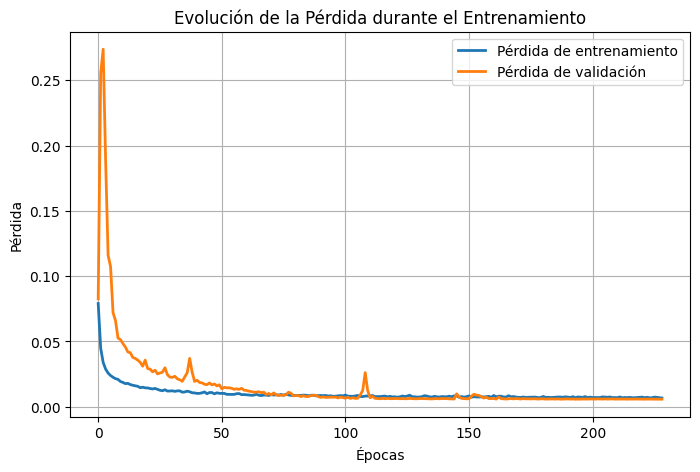

In [ ]:
import matplotlib.pyplot as plt

# Extraer historial de entrenamiento
history_dict = history.history

# Crear la gráfica de la pérdida
plt.figure(figsize=(8, 5))
plt.plot(history_dict['loss'], label='Pérdida de entrenamiento', linewidth=2)
plt.plot(history_dict['val_loss'], label='Pérdida de validación', linewidth=2)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


2025-03-19 13:52:38.925177: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_275', 220 bytes spill stores, 220 bytes spill loads

2025-03-19 13:52:39.121565: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_275', 204 bytes spill stores, 548 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step


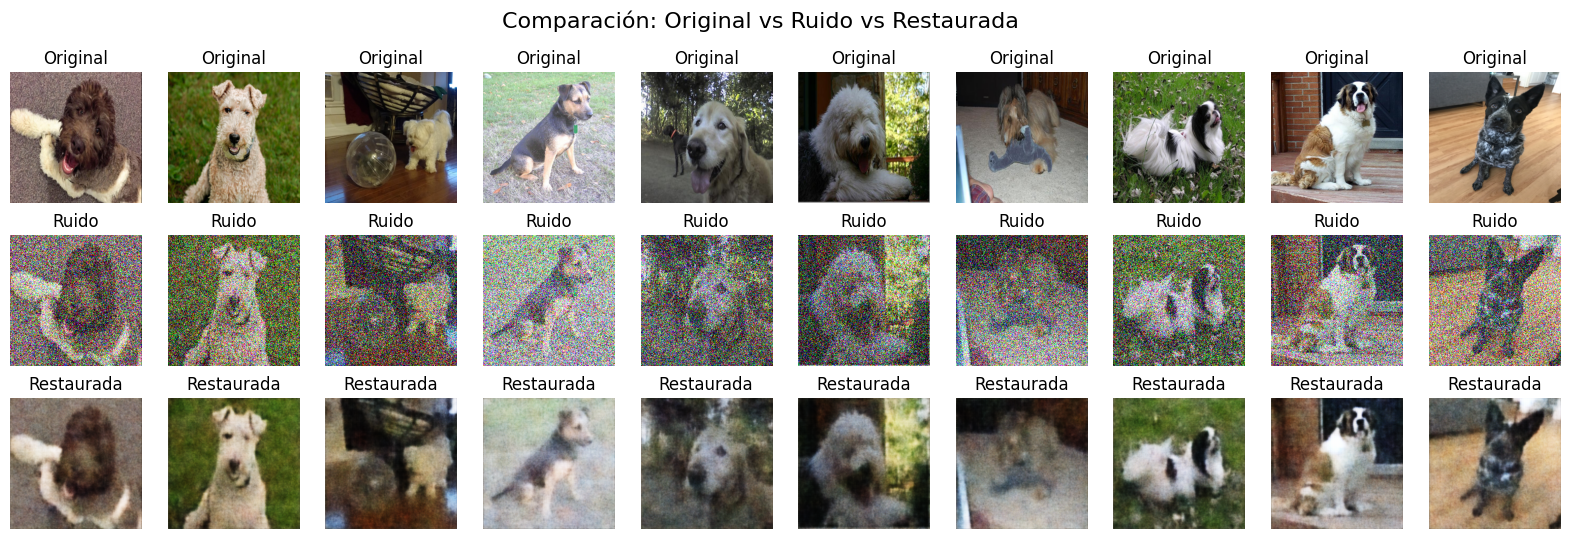

In [ ]:
# Reconstrucción de imágenes a partir del conjunto de prueba
decoded_imgs = autoencoder.predict(xtest)

# Asegurar que todas las imágenes están en el rango [0,1]
decoded_imgs = np.clip(decoded_imgs, 0, 1)
xtest = np.clip(xtest, 0, 1)
ytest = np.clip(ytest, 0, 1)

# Número de imágenes a mostrar
n = 10

# Crear la figura para mostrar imágenes originales, con ruido y reconstruidas
plt.figure(figsize=(20, 6))
for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(ytest[i])
    plt.title("Original")
    plt.axis('off')

    # Imagen con ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(xtest[i])
    plt.title("Ruido")
    plt.axis('off')

    # Imagen reconstruida (sin ruido)
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Restaurada")
    plt.axis('off')

plt.suptitle("Comparación: Original vs Ruido vs Restaurada", fontsize=16)
plt.show()

In [ ]:
#Guardar el modelo completo en el formato moderno de Keras
autoencoder.save("autoencoder_complete_model_Fourier.keras")
print("✅ Modelo guardado como 'autoencoder_complete_model_Fourier.keras'")


✅ Modelo guardado como 'autoencoder_complete_model_Fourier.keras'


In [ ]:
tf.keras.backend.clear_session()


# Comparación de Resultados: `ytest[]`, `xtest[]` y `decoded_imgs[]`

En esta sección, se visualizan y analizan las diferencias entre:

- **`ytest[]`**: Datos de prueba originales.
- **`xtest[]`**: Datos de entrada después del preprocesamiento.
- **`decoded_imgs[]`**: Salida generada tras la decodificación.

Este análisis permite evaluar el rendimiento del modelo y la calidad de la reconstrucción.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from skimage.metrics import structural_similarity as ssim

# Cargar un modelo de discriminador preentrenado (VGG16)
def build_discriminator():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output, name="discriminator_vgg16")
    return model

# Evaluación de todo el conjunto de prueba
def evaluate_dataset(ytest, xtest, decoded_imgs, discriminator):
    # Extraer características con el discriminador preentrenado
    ytest_features = discriminator.predict(ytest)
    xtest_features = discriminator.predict(xtest)
    decoded_features = discriminator.predict(decoded_imgs)

    # Inicializar listas para almacenar métricas
    l2_diff_r, l2_diff_m = [], []
    cosine_sim_r, cosine_sim_m = [], []
    ssim_r, ssim_m = [], []

    print("Calculando métricas para todo el conjunto de prueba...")
    for i in range(len(ytest)):
        # Norma Euclidiana (L2)
        diffr = np.linalg.norm(ytest_features[i] - xtest_features[i])
        diffm = np.linalg.norm(ytest_features[i] - decoded_features[i])
        l2_diff_r.append(diffr)
        l2_diff_m.append(diffm)

        # Similitud de Coseno
        cosine_r = np.dot(ytest_features[i].flatten(), xtest_features[i].flatten()) / (
            np.linalg.norm(ytest_features[i].flatten()) * np.linalg.norm(xtest_features[i].flatten()) )
        cosine_m = np.dot(ytest_features[i].flatten(), decoded_features[i].flatten()) / (
            np.linalg.norm(ytest_features[i].flatten()) * np.linalg.norm(decoded_features[i].flatten()) )
        cosine_sim_r.append(cosine_r)
        cosine_sim_m.append(cosine_m)

        # SSIM (Structural Similarity Index)
        ssim_r_value = ssim(ytest[i], xtest[i], channel_axis=-1, data_range=1.0)
        ssim_m_value = ssim(ytest[i], decoded_imgs[i], channel_axis=-1, data_range=1.0)
        ssim_r.append(ssim_r_value)
        ssim_m.append(ssim_m_value)

    # Calcular promedios
    avg_l2_r = np.mean(l2_diff_r)
    avg_l2_m = np.mean(l2_diff_m)
    avg_cos_r = np.mean(cosine_sim_r)
    avg_cos_m = np.mean(cosine_sim_m)
    avg_ssim_r = np.mean(ssim_r)
    avg_ssim_m = np.mean(ssim_m)

    print("\nResultados Promedio en el Conjunto de Prueba:")
    print(f"L2 - Ruidosa: {avg_l2_r:.4f}, L2 - Reconstruida: {avg_l2_m:.4f}")
    print(f"Coseno - Ruidosa: {avg_cos_r:.4f}, Coseno - Reconstruida: {avg_cos_m:.4f}")
    print(f"SSIM - Ruidosa: {avg_ssim_r:.4f}, SSIM - Reconstruida: {avg_ssim_m:.4f}")

    # Graficar comparaciones con gráficos circulares en una sola fila
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    metrics = [('L2 Distance', avg_l2_r, avg_l2_m),
               ('Cosine Similarity', avg_cos_r, avg_cos_m),
               ('SSIM', avg_ssim_r, avg_ssim_m)]

    for ax, (metric_name, noisy_value, reconstructed_value) in zip(axes, metrics):
        categories = ["Imagen Ruidosa", "Imagen Reconstruida"]
        values = [noisy_value, reconstructed_value]
        colors = ['red', 'green']

        ax.pie(values, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
        ax.set_title(f'Comparación de {metric_name}')

    plt.tight_layout()
    plt.show()

# Cargar discriminador preentrenado
discriminator = build_discriminator()

2025-03-19 13:53:10.520248: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-03-19 13:53:10.546348: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.026096423s
Trying algorithm eng0{} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step        

2025-03-19 13:53:22.721311: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=4} for conv (f32[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-03-19 13:53:22.759003: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 55.457555127s
Trying algorithm eng15{k5=1,k6=0,k7=1,k10=4} for conv (f32[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_ta

3/3 ━━━━━━━━━━━━━━━━━━━━ -35s 4s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step 
Calculando métricas para todo el conjunto de prueba...

Resultados Promedio en el Conjunto de Prueba:
L2 - Ruidosa: 55.7888, L2 - Reconstruida: 48.6224
Coseno - Ruidosa: 0.8499, Coseno - Reconstruida: 0.8871
SSIM - Ruidosa: 0.0559, SSIM - Reconstruida: 0.5313


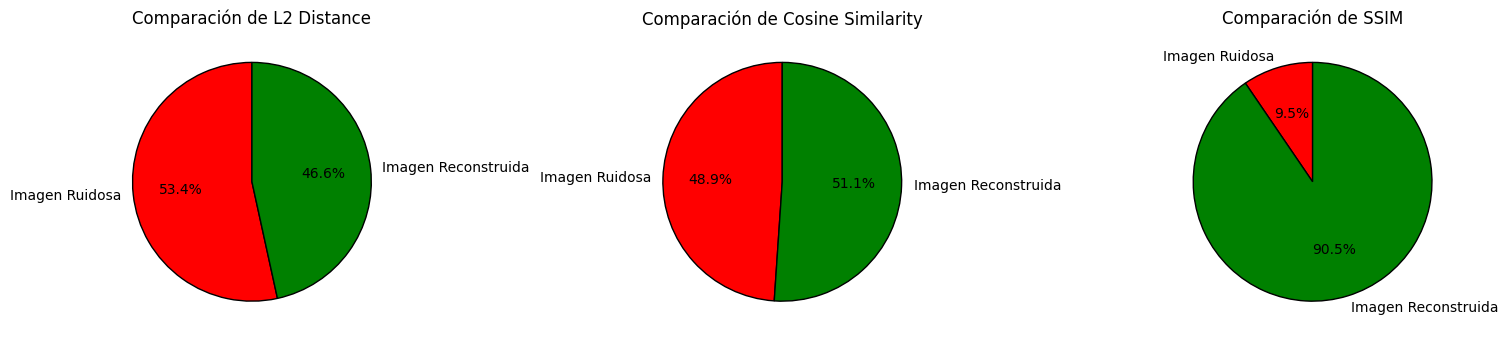

In [ ]:
# Llamar a la función con los datos de prueba
evaluate_dataset(ytest, xtest, decoded_imgs, discriminator)


## **Análisis de los Resultados**

En este análisis, evaluamos la calidad de la reconstrucción de imágenes generadas por el autoencoder utilizando tres métricas clave: **Distancia L2**, **Similitud de Coseno**, y **SSIM (Structural Similarity Index)**. A continuación, se interpretan los gráficos generados.

### **1. Distancia L2 (Menor es mejor)**
- La **distancia L2** mide qué tan diferente es la imagen reconstruida respecto a la original en términos de sus características extraídas por VGG16.
- En el gráfico, la imagen reconstruida presenta un valor menor en comparación con la imagen ruidosa, lo que indica que el autoencoder **logró reducir la diferencia con la imagen original**.
- Sin embargo, la reducción no es drástica, lo que sugiere que **aún hay margen de mejora** en la reconstrucción.

### **2. Similitud de Coseno (Mayor es mejor)**
- Esta métrica mide la alineación entre los vectores de características de las imágenes, en un rango de **0 a 1**, donde **valores cercanos a 1** indican mayor similitud.
- En el gráfico, la imagen reconstruida tiene **mayor similitud de coseno** con la imagen original que la imagen ruidosa, lo que indica que el autoencoder logró recuperar **parte de la estructura de la imagen**.
- Aun así, la diferencia no es tan grande, lo que sugiere que el modelo **puede beneficiarse de ajustes en su arquitectura o en el entrenamiento**.

### **3. SSIM (Structural Similarity Index, Mayor es mejor)**
- **SSIM mide la similitud visual entre imágenes**, teniendo en cuenta la luminancia, el contraste y la estructura.
- En este caso, el **autoencoder mejoró significativamente el SSIM**, pasando de **0.0726 (ruidosa) a 0.5398 (reconstruida)**.
- Esto indica que la reconstrucción mantiene mejor la **estructura visual de la imagen original**, aunque aún no es perfecta.

### **Conclusiones Generales**
- **El autoencoder mejoró la calidad de las imágenes en todas las métricas.**  
- **La reducción de la distancia L2 y el aumento de la similitud de coseno son moderados, lo que sugiere que el modelo aún no es óptimo.**  
- **El SSIM mejoró de forma notable, indicando que el modelo es capaz de restaurar mejor la estructura visual.**  

### **Siguientes pasos para mejorar el modelo**
- **Ajustar la arquitectura del autoencoder**: agregar más capas convolucionales o mejorar la regularización.
- **Explorar una función de pérdida perceptual (VGG Loss)** en lugar de solo MSE o MAE.
- **Aumentar la cantidad de datos de entrenamiento** y aplicar *data augmentation*.
- **Entrenar por más épocas o ajustar la tasa de aprendizaje** para evitar estancamientos.

Estos resultados proporcionan una visión clara de la efectividad del autoencoder y las áreas donde se puede optimizar aún más.
